### Excel＋Python（ArcGIS Online のアイテム詳細を一括更新）

#### [概要]

Excel に整理してあるArcGIS Online のアイテム詳細を、ArcGIS API for Python を使って、一括更新するスクリプトです。

同時にこのスクリプト内では、アイテムの削除防止の有効化、特定グループに共有、所有者の変更、パブリックで公開するまでを行っています。

弊社では[ArcGIS Hub Basic](https://www.esrij.com/products/arcgis-hub/) の機能を使って作成した「[3D 都市モデルの ArcGIS における活用事例を集めた活用サイト](https://3d-city-model.esrij.com/)」に掲載したファイル ジオデータベース (FGDB) のアイテム詳細の更新時にこのスクリプトを利用しました。

特定グループは任意にidで指定可能ですが、今回の場合は、弊社のArcGIS Online 組織サイト（https://ej.maps.arcgis.com/ ）の「国土交通省 3D都市モデル 「Project PLATEAU」の活用 のコンテンツ」(id:d568e2190c4f456f8bd812c8e07c719a) のグループに共有することで、ArcGIS Hub 側で情報の登録を重複して行うことことなく、最終的には、[カタログサイト](https://3d-city-model.esrij.com/search?collection=Document&sort=name) から、*105* のアイテムを公開した状態になっております。

Excel の整理例は、[3D都市モデル_AGOLアイテム詳細_開発テスト用.xlsx] として提供しておりますので、あわせてご参照ください。

#### [参考1]- Pure Python で CSV から REST API で更新するスクリプト：

[Replace item details for content in ArcGIS Online and Portal for ArcGIS](https://gist.github.com/ecaldwell/7e8a993946f3aa0e2135)
  
#### [参考2]- ArcGIS API for Python のガイド：

https://developers.arcgis.com/python/guide/managing-your-content/

#### [参考3]- ArcGIS API for Python のAPI リファレンス（class arcgis.gis.Item）：

https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item

> アイテム情報の更新:  
> [update(item_properties=None, data=None, thumbnail=None, metadata=None)](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.update)
> 
> item_properties で指定可能なディクショナリ key の一覧は、Helpに記載があります。
> (type, typeKeywords, description, title, url, tags, text, snippet, extent, spatialReference, accessInformation, licenseInfo, culture, access, commentsEnabled)

> アイテムの共有:  
> [share(everyone=False, org=False, groups=None, allow_members_to_edit=False)](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.share)

> 所有者の変更:  
> [reassign_to(target_owner, target_folder=None)](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.reassign_to)


### 手順

#### (1) Pandas のDataFrame にExcel データを読み込み

※ xlrdバージョン 2.0.0 から"xls"のみサポートに変更されたとのことで、お使いの環境によってはpd.read_excel で"xlsx"を読み込む時に、openpyxl engine を指定する必要がある場合があります。
ArcGIS Pro でクローンした環境の場合は、xlrdバージョン1.2.0 なので、基本的には指定する必要はありません。
  
> engine を指定した読み込み例）  
> df = pd.read_excel(excel_file)  
> →  
> df = pd.read_excel(excel_file,engine='openpyxl')  
  
[xlrd に関する参考サイト]  
https://xlrd.readthedocs.io/en/latest/changes.html

https://pandas.pydata.org/docs/whatsnew/v1.2.0.html


次のようにしてxlrd のバージョンを確認できます。

In [1]:
import xlrd
xlrd_version = xlrd.__version__
print(xlrd_version)

1.2.0


In [2]:
import pandas as pd
excel_file = r"your_folder_path\3D都市モデル_AGOLアイテム詳細_開発テスト用.xlsx"

In [3]:
df = pd.read_excel(excel_file) #sheet1を取得
#df = pd.read_excel(excel_file,engine='openpyxl')

読み込みしたExcel のカラムを確認してみます

In [4]:
df.columns

Index(['id', 'title', 'snippet', 'description', 'tags', 'licenseInfo',
       'accessInformation', '市区町村名', 'S3のURL', 'S3サイズ', 'G空間情報センターURL',
       '格納データ', '変換したCityGML更新日', '3D都市モデル変換ツールURL', 'アイテム詳細の更新日'],
      dtype='object')

#### (2) ArcGIS Online の組織サイトに接続し、アイテム情報の更新と、特定グループに共有します

組織サイトに接続して、Excelの 'id' をもとにアイテムを取得し、そのアイテムの 'title', 'snippet', 'description', 'tags', 'licenseInfo', 'accessInformation' をitem.update() で更新します。ついでに、アイテムのprotect() で削除防止を有効に設定、さらにshare() で組織と特定グループにアイテムを共有する設定を行っています。

item_properties で指定可能なディクショナリ key と、画面の文言の対応は次の通り。
* title : タイトル 
* snippet : サマリー
* description : 説明（HTMLを利用可能）
* tags : タグ（複数の場合はカンマ区切りで指定。※空白スペースもタグの一部になるので余計なスペースは入れない）
* licenseInfo : 利用規約
* accessInformation : 著作権

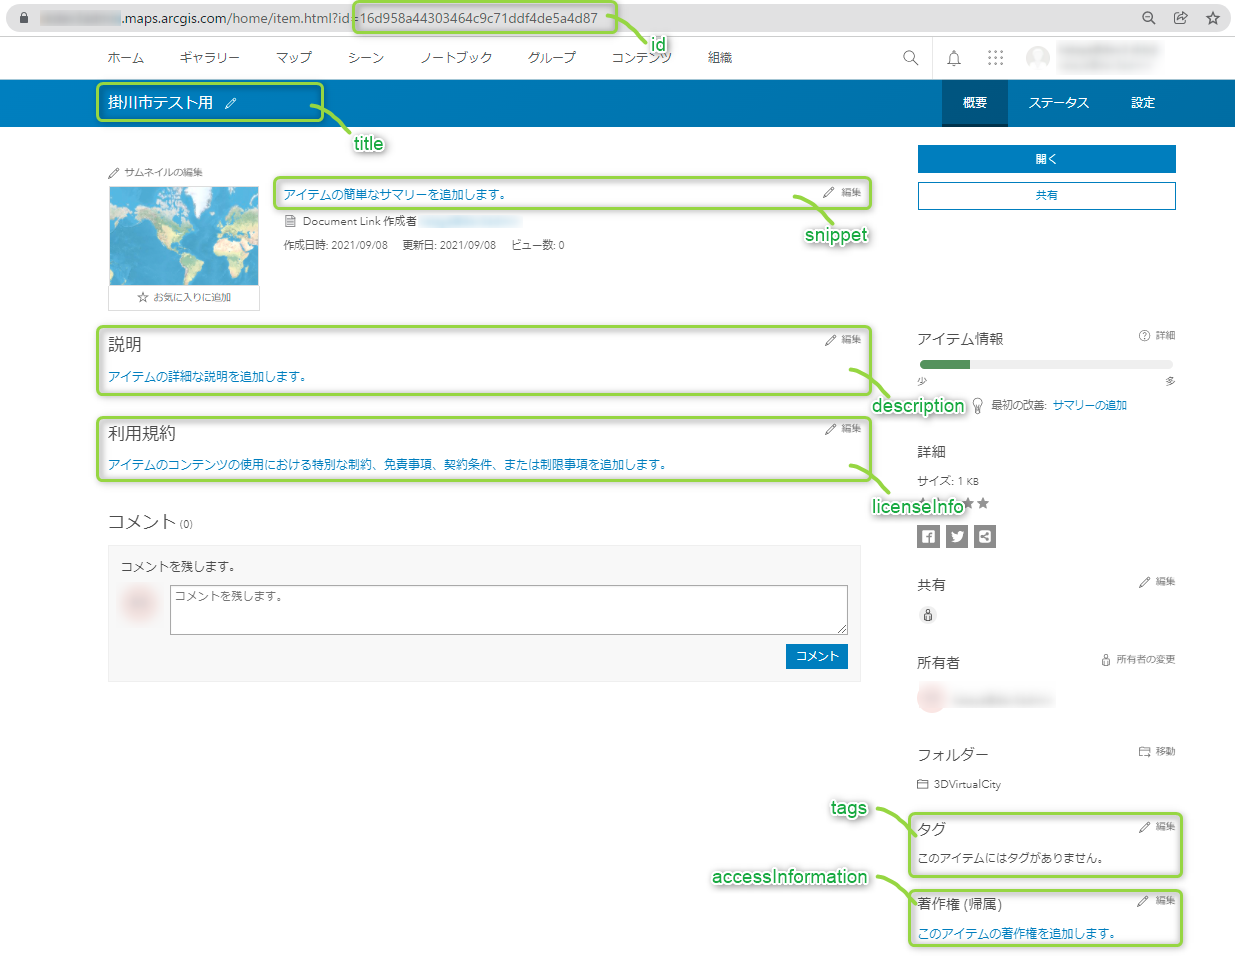

In [5]:
from arcgis.gis import GIS
gis = GIS("https://www.arcgis.com/", "your_username", "your_password") #"your_username", "your_password")

In [6]:
for index, row in df.iterrows():
    item_id = row[0] # id を取得
    item_properties = row[1:7].to_dict() # title～accessInformation をdictionary として取得
    my_item = gis.content.get(item_id) # アイテムを取得
    my_item.update(item_properties) # item.update() で、アイテムのtitle～accessInformation の情報を更新
    my_item.protect(enable = True) #うっかり削除を防止するため、アイテムの削除防止を有効に設定 
    my_item.share(org= True, groups=['share_group_id']) # 組織と特定グループに共有 - テスト環境；「Open Data 共有のコンテンツ」(id:f862b4f5d32f435596795947df012042)、本番環境；「国土交通省 3D都市モデル 「Project PLATEAU」の活用 のコンテンツ」(id:d568e2190c4f456f8bd812c8e07c719a)

#### (3) 管理者でArcGIS Online の組織サイトに接続し、アイテムの所有者変更と、特定グループへの共有、パブリックに公開を実施

※ 本来、（2）までのステップとここのステップは操作する人が異なっていたり、業務上のプロセスも異なる場合があるため、別のノートブックに分けておいた方が得策かもしれませんが、今回は、便宜上同じノートブック に記載しております。

次のステップとして、最初にアイテムの所有者を変更（※必須ではないが、今回の場合は、個人から弊社の公開用アカウントに変更）し、その後、新しい所有者が共有先を特定グループ共有と、パプリック公開を行う

In [7]:
gisadmin = GIS("https://www.arcgis.com/", "your_admin_username", "your_admin_password") #管理者 

In [9]:
for index, row in df.iterrows():
    item_id = row[0] # id
    my_item = gisadmin.content.get(item_id)
    # 最初に所有者変更
    my_item.reassign_to("new_owner_name") # テスト環境；"kataya@dev3admin"、本番環境："Esri_Japan"
    # ArcGIS Hub での公開するコンテンツとして反映させるために、所有者変更の後に、再度、組織の特定グループ共有とパブリック公開を行う
    my_item.share(everyone = True, org= True, groups=['share_group_id']) # 組織と特定グループに共有 - テスト環境；「Open Data 共有のコンテンツ」(id:f862b4f5d32f435596795947df012042)、本番環境；「国土交通省 3D都市モデル 「Project PLATEAU」の活用 のコンテンツ」(id:d568e2190c4f456f8bd812c8e07c719a)